In [1]:
%load_ext autoreload
%autoreload 2

# import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import uproot
from scipy.stats import iqr

from hepattn.experiments.clic.performance.performance import Performance
from hepattn.experiments.clic.performance.plot_helper_event import (
    compute_jet_residual_dict,
    plot_jet_marginals,
    plot_jet_res_boxplot,
    plot_jet_residuals,
    plot_jet_response,
    plot_met_res_and_ht_res,
)
from hepattn.experiments.clic.performance.plot_helper_particle import plot_eff_fr_purity, plot_residuals, plot_residuals_neutrals

In [29]:
import awkward as ak

In [177]:
dd = ak.from_parquet("/srv01/agrp/dmitrykl/projects/mlpf/data/pyg-clic_20250309_173756_957486/test/preds_common_checkpoint-10-1.939268/clic_edm_qq_pf/pred_0_0.parquet")

In [178]:
dd['event_idx']

<Array [0, 1, 2, 3, 4, 5, ..., 250, 251, 252, 253, 254, 255] type='256 * int64'>

In [170]:
td = ak.from_parquet("/srv01/agrp/dmitrykl/projects/mlpf/data/test_for_mlpf/merged_chunk_11.parquet")

In [171]:
td

<Record {X_track: [[...], ...], ...} type='{X_track: 5000 * var * var * flo...'>

In [144]:
np.argwhere(dd['genmet'].to_numpy().flatten() == np.sort(dd['genmet'].to_numpy().flatten())[::-1][0])

array([[136]])

In [146]:
dd['genmet'][136, 0]

np.float64(79.22759246826172)

In [148]:
np.argwhere(td['genmet'].to_numpy() == np.sort(td['genmet'].to_numpy().flatten())[::-1][1])

array([[136]])

In [150]:
td['genmet'][136]

np.float64(79.22759246826172)

In [235]:
save_dir = "maskformer_infer_best_mlpf"
SAVE_FIG = True

In [236]:
Path(save_dir).mkdir(parents=True, exist_ok=True)

In [204]:
net_dict = {
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFix_20250611-T181526/ckpts/epoch=172-val_loss=3.29018__test.root",
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test.root",
    # "mpflow":   "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test__common.root",

    "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFocFix_20250613-T142512/ckpts/epoch=159-val_loss=3.51694__test__common.root",
    "hgpflow": "/storage/agrp/nilotpal/HGPFlow_v2/experiments/hgpflow_v2/clicxminixbig1x2xs2xxxds7kirm1yo/inference/ee_qq_new/pred_test_p8_ee_qq_ecm380_20k_seg_bw0.3_nocut_merged.root",
    "mlpf": "/srv01/agrp/dmitrykl/projects/mlpf/data/pyg-clic_20250309_173756_957486/test/preds_common_checkpoint-10-1.939268/clic_edm_qq_pf/"
    # 'hgpflow'
}

In [205]:
perf_obj = Performance(
    # truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_common_raw.root",
    truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_raw.root",
    networks=net_dict,
    # num_events=10000,
    # num_events={
    #     'mpflow' : 25_000,
    # }
)

E, pT will be scaled by 1


Reading truth tree...: 100%|██████████| 11/11 [00:01<00:00,  6.82it/s]


Number of events with at least one track or topocluster: 19998 out of 20000
[[ 1399]
 [11288]]
Number of events after filtering: 19998


Loading MLPF predictions...: 100%|██████████| 79/79 [00:02<00:00, 33.91it/s, file=pred_0_78.parquet]


['cls_binary', 'cls_id_onehot', 'momentum', 'ispu', 'pt', 'eta', 'sin_phi', 'cos_phi', 'energy', 'cls_id', 'phi', 'p4']


Computing MLPF mass...: 100%|██████████| 19993/19993 [00:00<00:00, 132611.03it/s]


In [206]:
perf_obj.reorder_and_find_intersection()

common event count: 19717


Filtering and reordering mlpf...: 100%|██████████| 9/9 [00:00<00:00, 1575.62it/s]


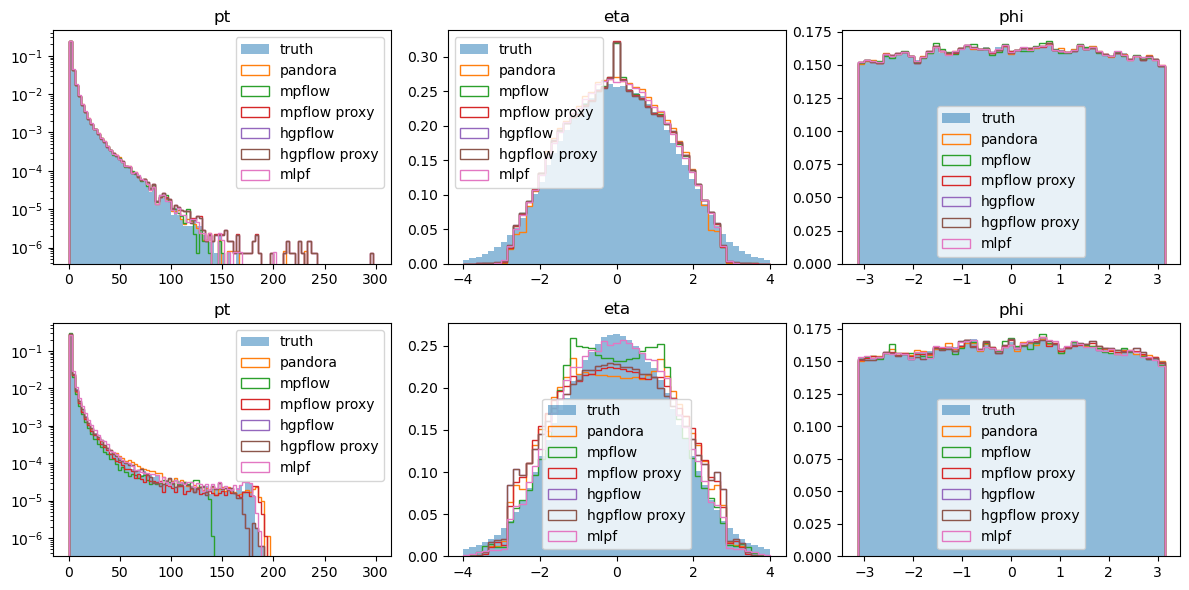

In [237]:
bins = [
    np.linspace(0, 300, 100),
    np.linspace(-4, 4, 50),
    np.linspace(-np.pi, np.pi, 50),
]
var_names = ["pt", "eta", "phi"]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
mask_fns = [
    lambda x: x < 3,
    lambda x: (x < 5) & (x > 2),
]
truth_class = np.concatenate(perf_obj.truth_dict["particle_class"])
pandora_class = np.concatenate(perf_obj.truth_dict["pandora_class"])

for i in range(3):
    for j in range(2):
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["particle_" + var_names[i]])[mask_fns[j](truth_class)],
            bins=bins[i],
            histtype="stepfilled",
            alpha=0.5,
            label="truth",
            density=True,
        )
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["pandora_" + var_names[i]])[mask_fns[j](pandora_class)],
            bins=bins[i],
            histtype="step",
            label="pandora",
            density=True,
        )
        for key, value in perf_obj.data.items():
            pf_class = np.concatenate(value["class"])
            ax[j, i].hist(
                np.concatenate(value[var_names[i]])[mask_fns[j](pf_class)],
                bins=bins[i],
                histtype="step",
                label=key,
                density=True,
            )
            if key in {"hgpflow", "mpflow"}:
                ax[j, i].hist(
                    np.concatenate(value["proxy_" + var_names[i]])[mask_fns[j](pf_class)],
                    bins=bins[i],
                    histtype="step",
                    label=key + " proxy",
                    density=True,
                )
        ax[j, i].set_title(var_names[i])
        ax[j, i].legend()
        ax[j, 0].set_yscale("log")

plt.tight_layout()
plt.show()

In [238]:
def get_n_particles(data_dict, key="class"):
    n_charged = []
    n_neutral = []
    for i in range(len(data_dict[key])):
        ch_mask = data_dict[key][i] <= 2
        n_charged.append(np.sum(ch_mask))
        n_neutral.append(np.sum(~ch_mask))
    return np.array(n_charged), np.array(n_neutral)

In [239]:
n_charged_truth, n_neutral_truth = get_n_particles(perf_obj.truth_dict, key="particle_class")
n_charged_pandora, n_neutral_pandora = get_n_particles(perf_obj.truth_dict, key="pandora_class")

for key in perf_obj.data:
    n_charged, n_neutral = get_n_particles(perf_obj.data[key])
    perf_obj.data[key]["n_charged"] = n_charged
    perf_obj.data[key]["n_neutral"] = n_neutral

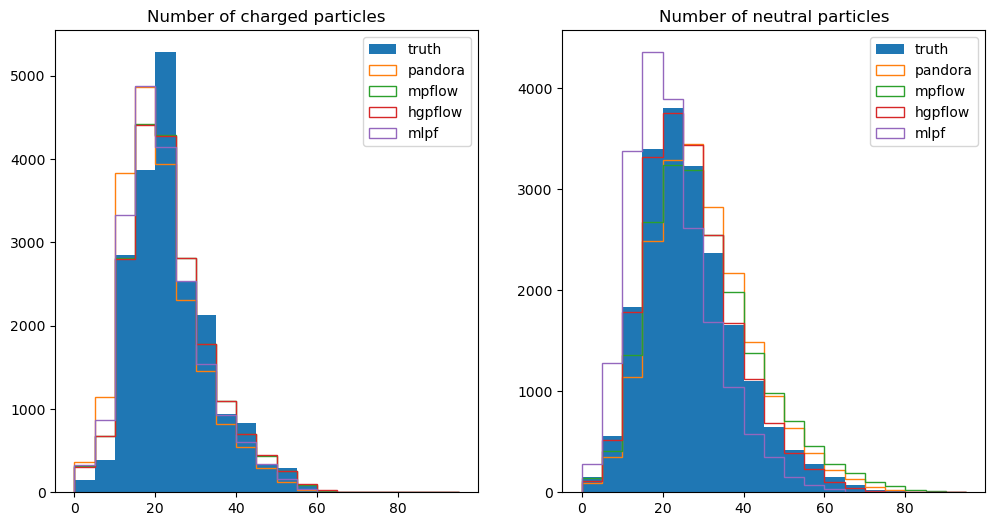

In [240]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(n_charged_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[1].hist(n_neutral_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[0].hist(n_charged_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
ax[1].hist(n_neutral_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
for key in perf_obj.data:
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    ax[0].hist(n_charged, bins=np.arange(0, 100, 5), histtype="step", label=key)
    ax[1].hist(n_neutral, bins=np.arange(0, 100, 5), histtype="step", label=key)
ax[0].legend()
ax[1].legend()
ax[0].set_title("Number of charged particles")
ax[1].set_title("Number of neutral particles")
plt.show()

In [242]:
from scipy.stats import iqr

In [243]:
def _add_hist(ax, data, bins, label, histtype="step", **kwargs):
    mean, iqr_ = np.mean(data), iqr(data)
    label = rf"{label}: $\mu$={mean:.2f}, iqr={iqr_:.2f}"
    ax.hist(data, bins=bins, histtype=histtype, label=label, **kwargs)

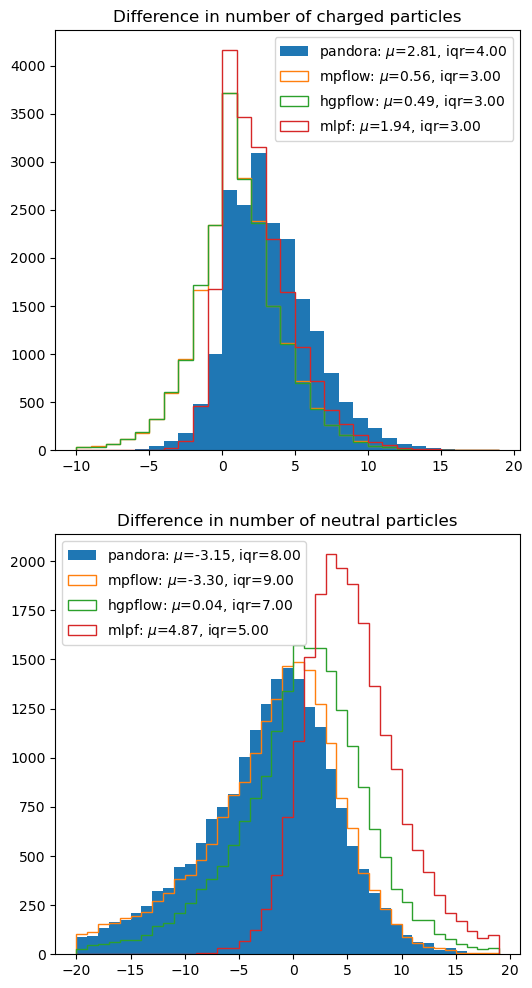

In [245]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
_add_hist(ax[0], n_charged_truth - n_charged_pandora, bins=np.arange(-10, 20, 1), histtype="stepfilled", label="pandora")
_add_hist(ax[1], n_neutral_truth - n_neutral_pandora, bins=np.arange(-20, 20, 1), histtype="stepfilled", label="pandora")
for key in perf_obj.data:
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    _add_hist(ax[0], n_charged_truth - n_charged, bins=np.arange(-10, 20, 1), label=key, histtype="step")
    _add_hist(ax[1], n_neutral_truth - n_neutral, bins=np.arange(-20, 20, 1), label=key, histtype="step")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Difference in number of charged particles")
ax[1].set_title("Difference in number of neutral particles")
plt.show()

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [246]:
# perf_obj.data["hgpflow"]["eta"] = perf_obj.data["hgpflow"]["proxy_eta"]
# perf_obj.data["hgpflow"]["phi"] = perf_obj.data["hgpflow"]["proxy_phi"]
# perf_obj.data["hgpflow"]["pt"] = perf_obj.data["hgpflow"]["proxy_pt"]

# for i in range(len(perf_obj.data["hgpflow"]["pt"])):
#     ch_mask = perf_obj.data["hgpflow"]["class"][i] <= 2
#     perf_obj.data["hgpflow"]["pt"][i][ch_mask] = perf_obj.data["hgpflow"]["proxy_pt"][i][ch_mask]

In [247]:
idx = 0

print("Particle data")
print(np.sort(perf_obj.truth_dict["particle_pt"][idx][perf_obj.truth_dict["particle_class"][idx] <= 2])[::-1])
print("MPflow proxy data")
print(np.sort(perf_obj.data["mpflow"]["proxy_pt"][idx][perf_obj.data["mpflow"]["class"][idx] <= 2])[::-1])
print("HGPflow proxy data")
print(np.sort(perf_obj.data["hgpflow"]["proxy_pt"][idx][perf_obj.data["hgpflow"]["class"][idx] <= 2])[::-1])
print("MLPF data")
print(np.sort(perf_obj.data["mlpf"]["pt"][idx][perf_obj.data["mlpf"]["class"][idx] <= 2])[::-1])

Particle data
[2.05544543 2.00689816 1.22862697 1.21958816 0.94735843 0.93824512
 0.68863207 0.58046174 0.57142735 0.56641656 0.51084858 0.45804888
 0.45783955 0.3199735  0.26255557 0.26148829 0.2348657  0.2299964
 0.22890501 0.17870697]
MPflow proxy data
[2.055761   2.0023139  1.2279531  1.2232833  0.94966733 0.946075
 0.6072137  0.5837236  0.5793992  0.5742155  0.5266971  0.45971563
 0.45850793 0.3203549  0.26150483 0.23455955 0.22790605 0.18378448
 0.14520137]
HGPflow proxy data
[2.05576396 2.00231266 1.22795367 1.22328472 0.94966805 0.9460755
 0.60721451 0.58372396 0.57940006 0.57421535 0.52669764 0.45971563
 0.45850775 0.3203547  0.26150483 0.23455988 0.22790605 0.18378502
 0.14520177]
MLPF data
[2.0540466  2.00044    1.2734447  1.2424321  0.9495173  0.94490284
 0.60687023 0.57884586 0.5741111  0.5265312  0.45974845 0.45842868
 0.32013002 0.2635237  0.26298696 0.2335822  0.22796044 0.18398328]


In [40]:
with uproot.open("/share/gpu1/syw24/dmitrii_clic/test_clic_common_infer.root") as f:
    track_pt = f["EventTree"]["track_pt"].array(library="np")

KeyboardInterrupt: 

In [ ]:
track_pt[0]

In [216]:
perf_obj.compute_jets(n_procs=20)
perf_obj.match_jets()

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7
truth
pandora
mpflow jets
hgpflow jets
mlpf jets


Matching jets...: 100%|██████████| 19717/19717 [00:00<00:00, 56162.45it/s]


### Jet residual plots

In [258]:
_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_jets"],
    "mlpf": perf_obj.data["mlpf"]["matched_jets"],
    # 'mpflow': perf_obj.data['mpflow']['matched_jets'],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["matched_proxy_jets"],
    # 'hgpflow_target': perf_obj.data['hgpflow_target']['matched_jets'],
}

jet_residual_dict = compute_jet_residual_dict(_dict, dr_cut=0.1, leading_n_jets=2, pt_min=10)

/tmp/ipykernel_3620034/3857315038.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figs.tight_layout()


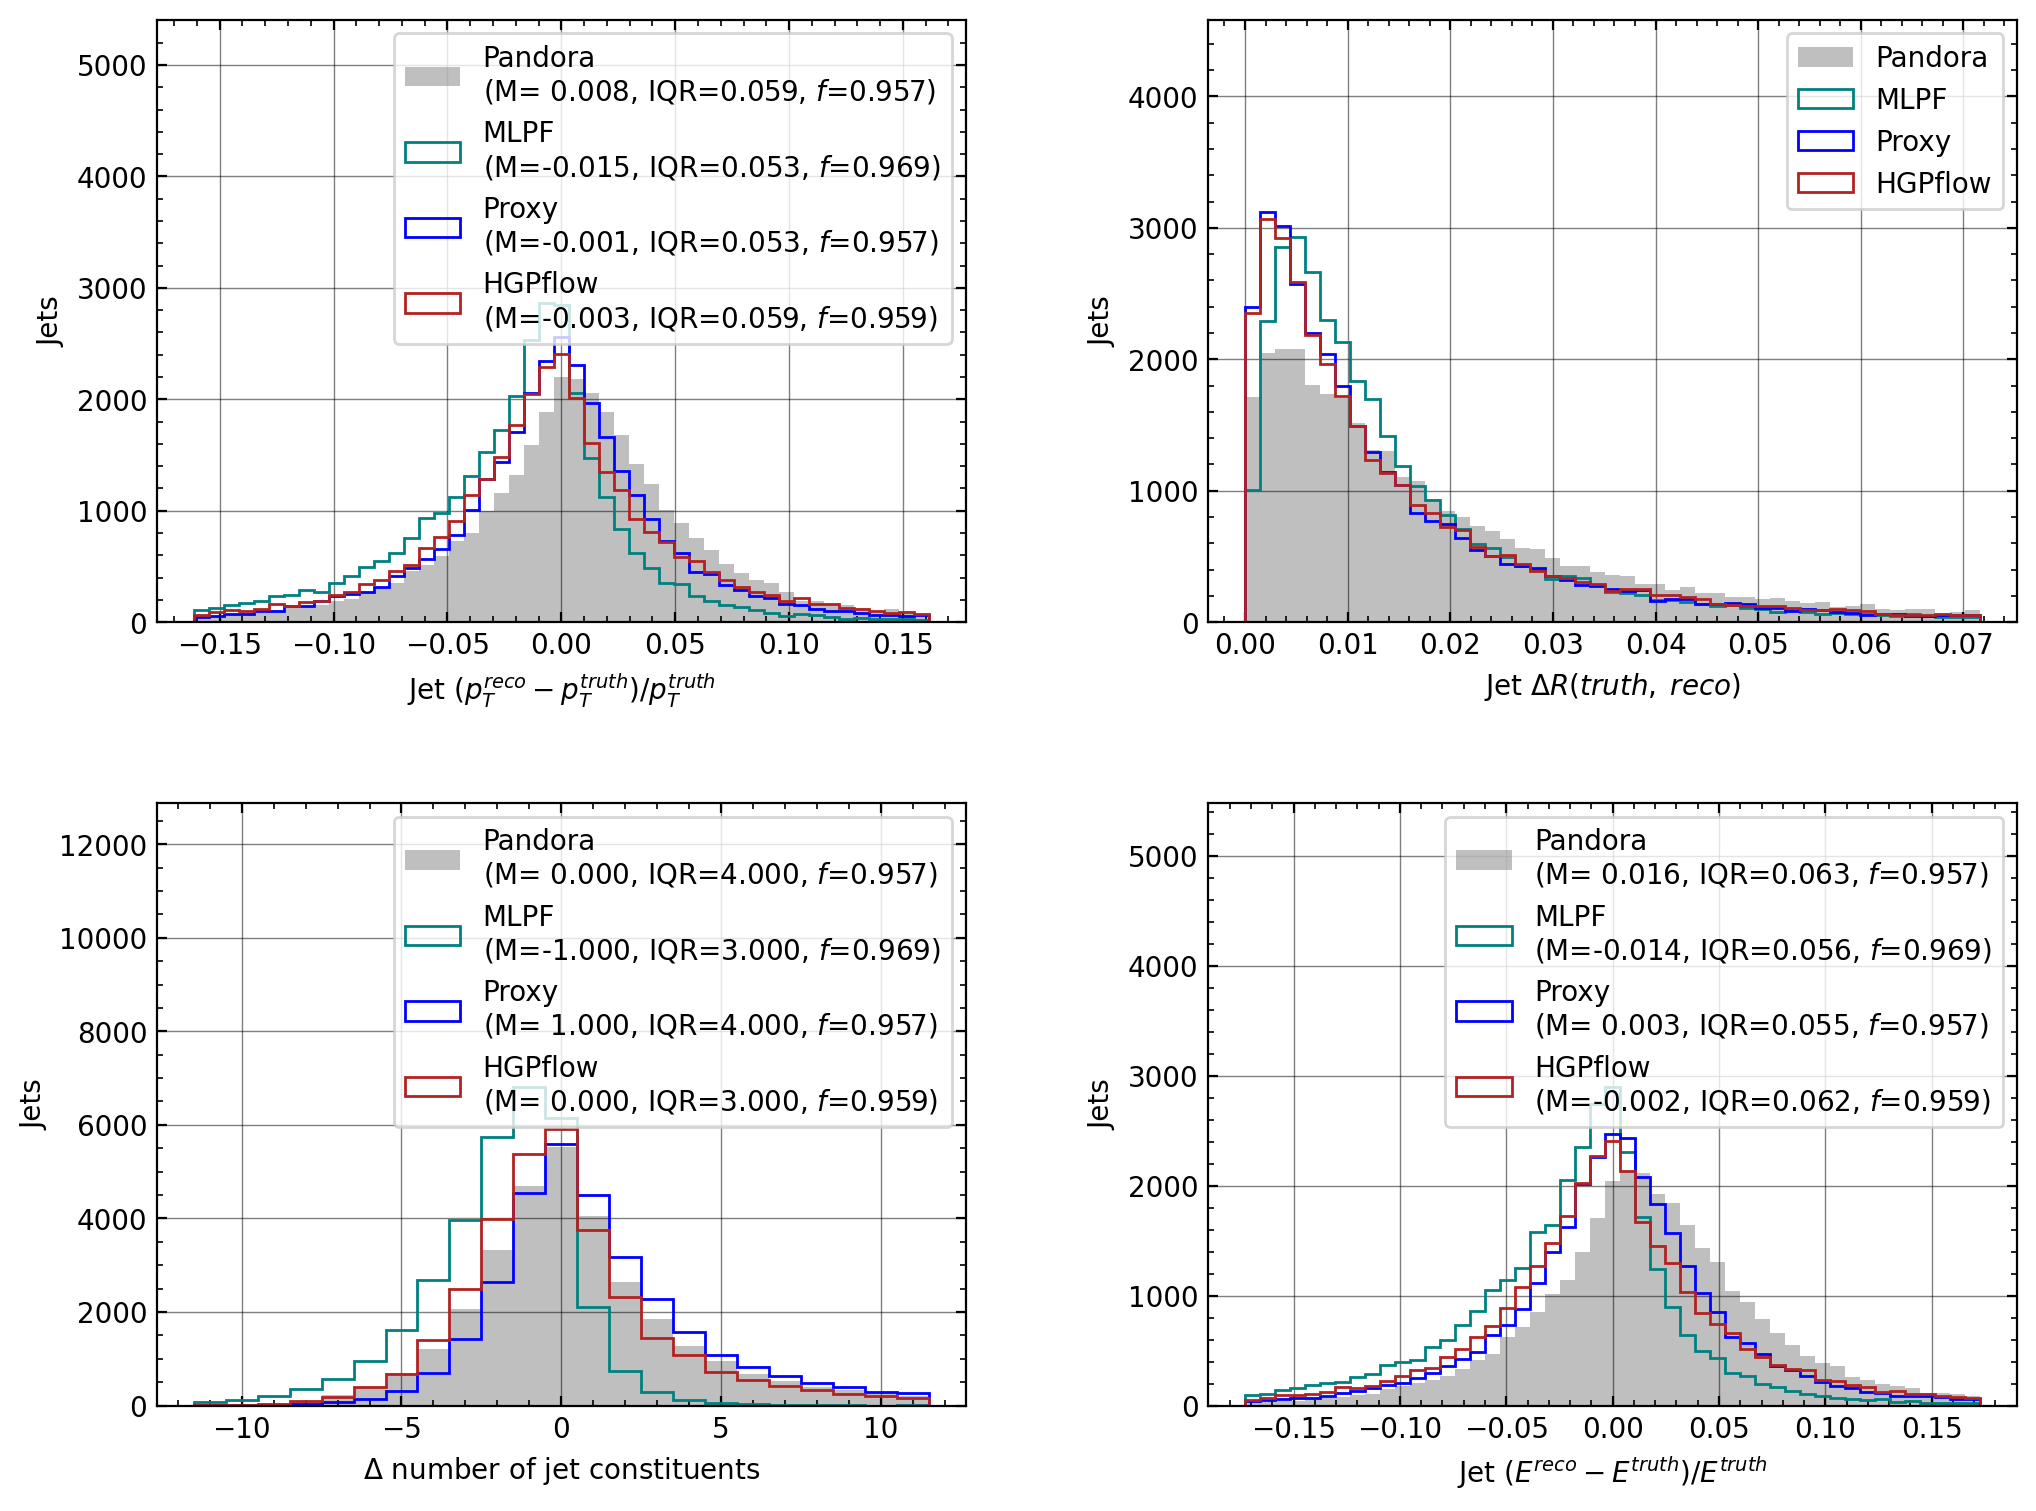

In [264]:
# change the x_lims

figs = plot_jet_residuals(jet_residual_dict, pt_relative=True, separate_figures=False, pt_relative2=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/clic_dijet_jet_residuals_pt.png", dpi=300)
        figs[1].savefig(f"{save_dir}/clic_dijet_jet_residuals_dr.png", dpi=300)
        figs[2].savefig(f"{save_dir}/clic_dijet_jet_residuals_constcount.png", dpi=300)
        figs[3].savefig(f"{save_dir}/clic_dijet_jet_residuals_e.png", dpi=300)
    else:
        figs.tight_layout()
        figs.savefig(f"{save_dir}/clic_dijet_jet_residuals.png", dpi=300, bbox_inches="tight")

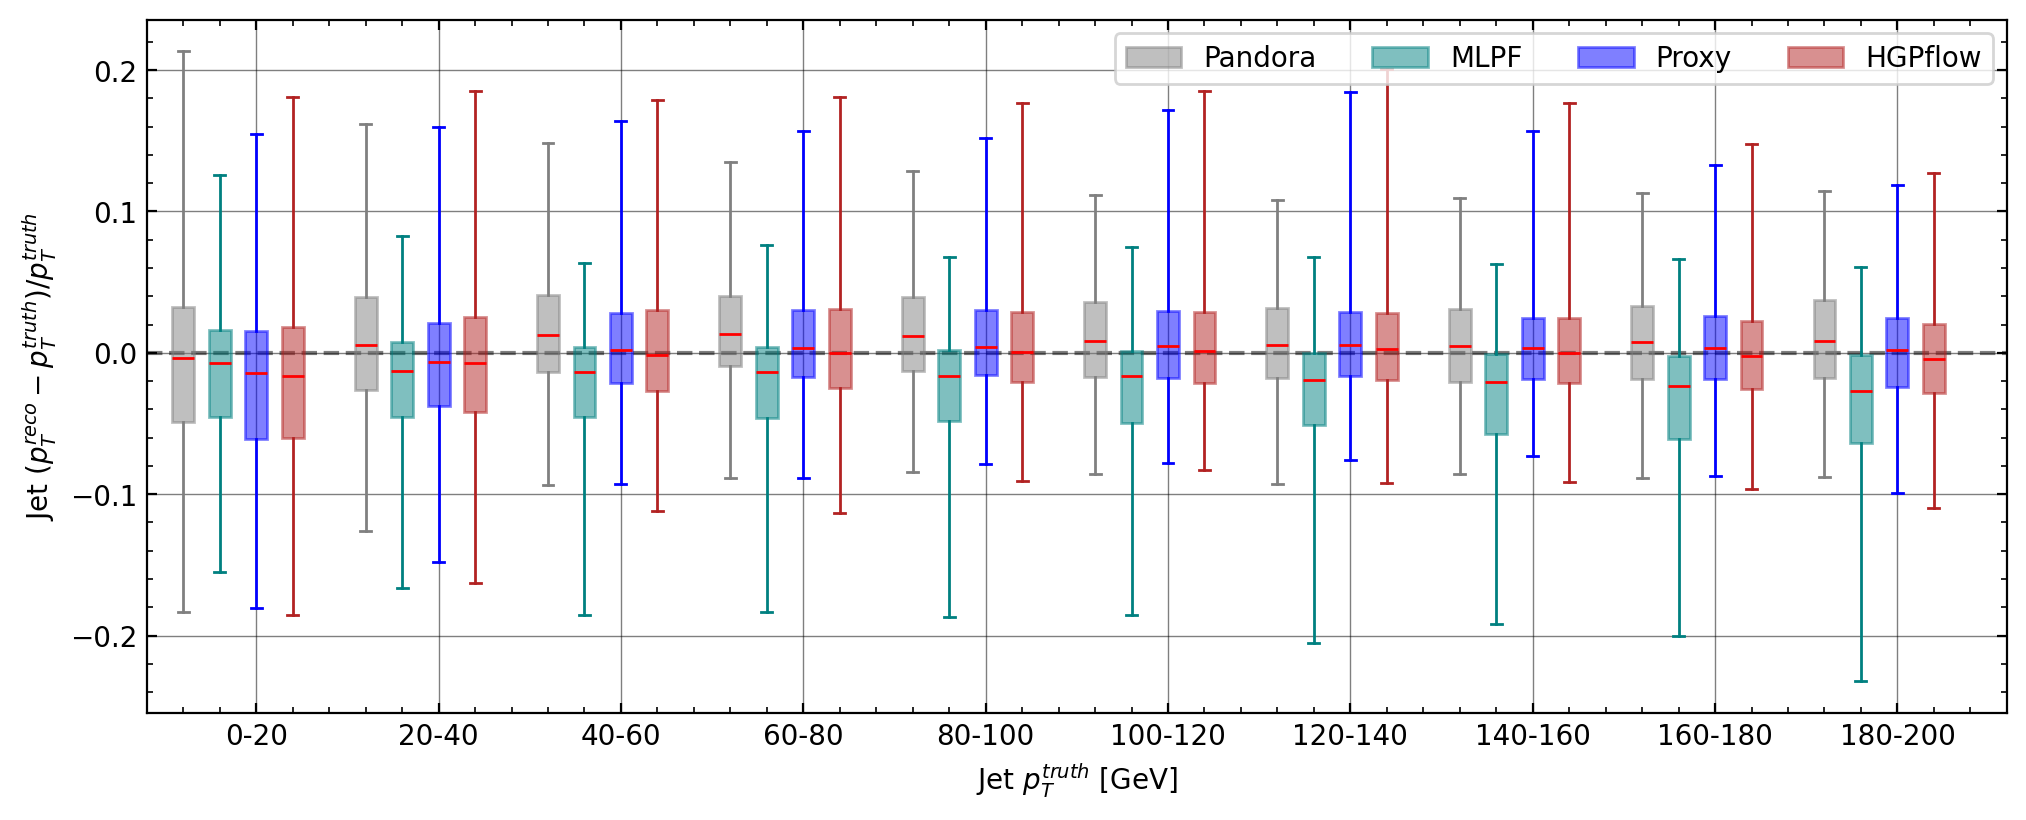

In [250]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_res_boxplot(jet_residual_dict, bins=pt_bins, var="pt")
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_residuals_boxplot_pt.png", dpi=300)

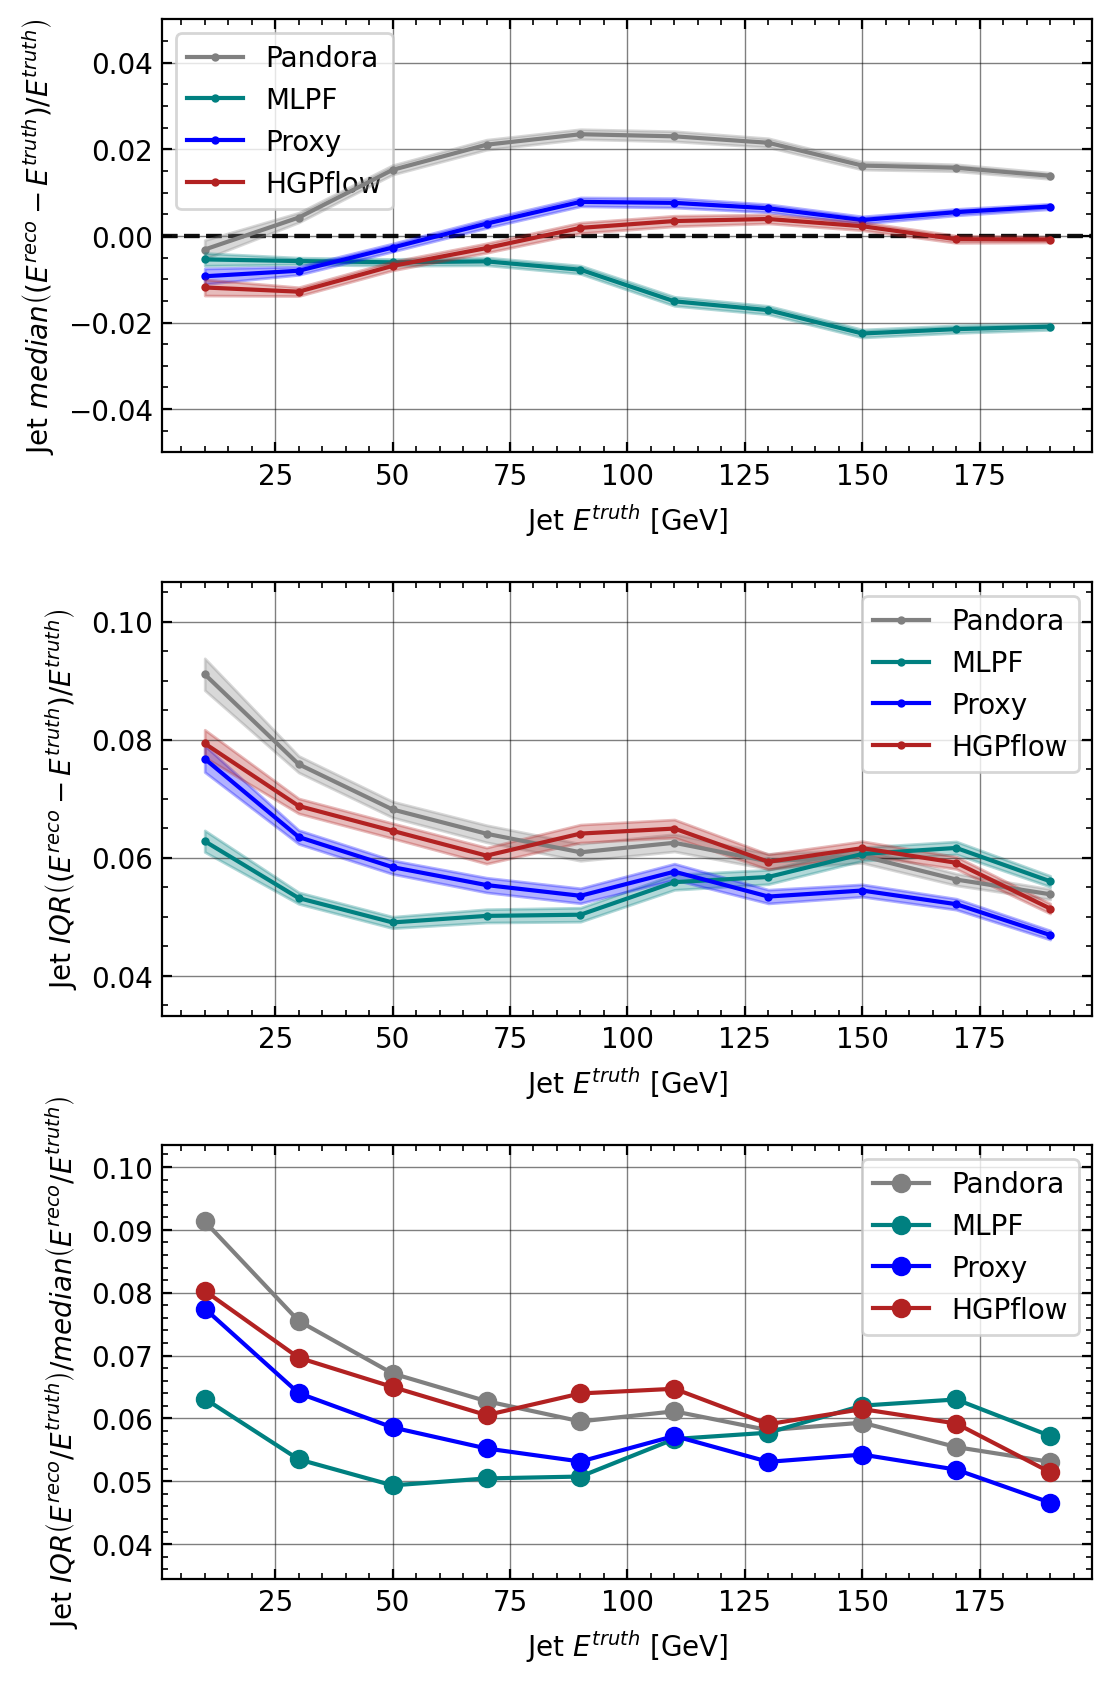

In [251]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_response(jet_residual_dict, pt_bins=pt_bins, use_energy=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(fig, list):
        for i, f in enumerate(fig):
            f.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot_{i}.png", dpi=300)
    else:
        fig.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot.png", dpi=300, bbox_inches="tight")

### jet marginal distributions

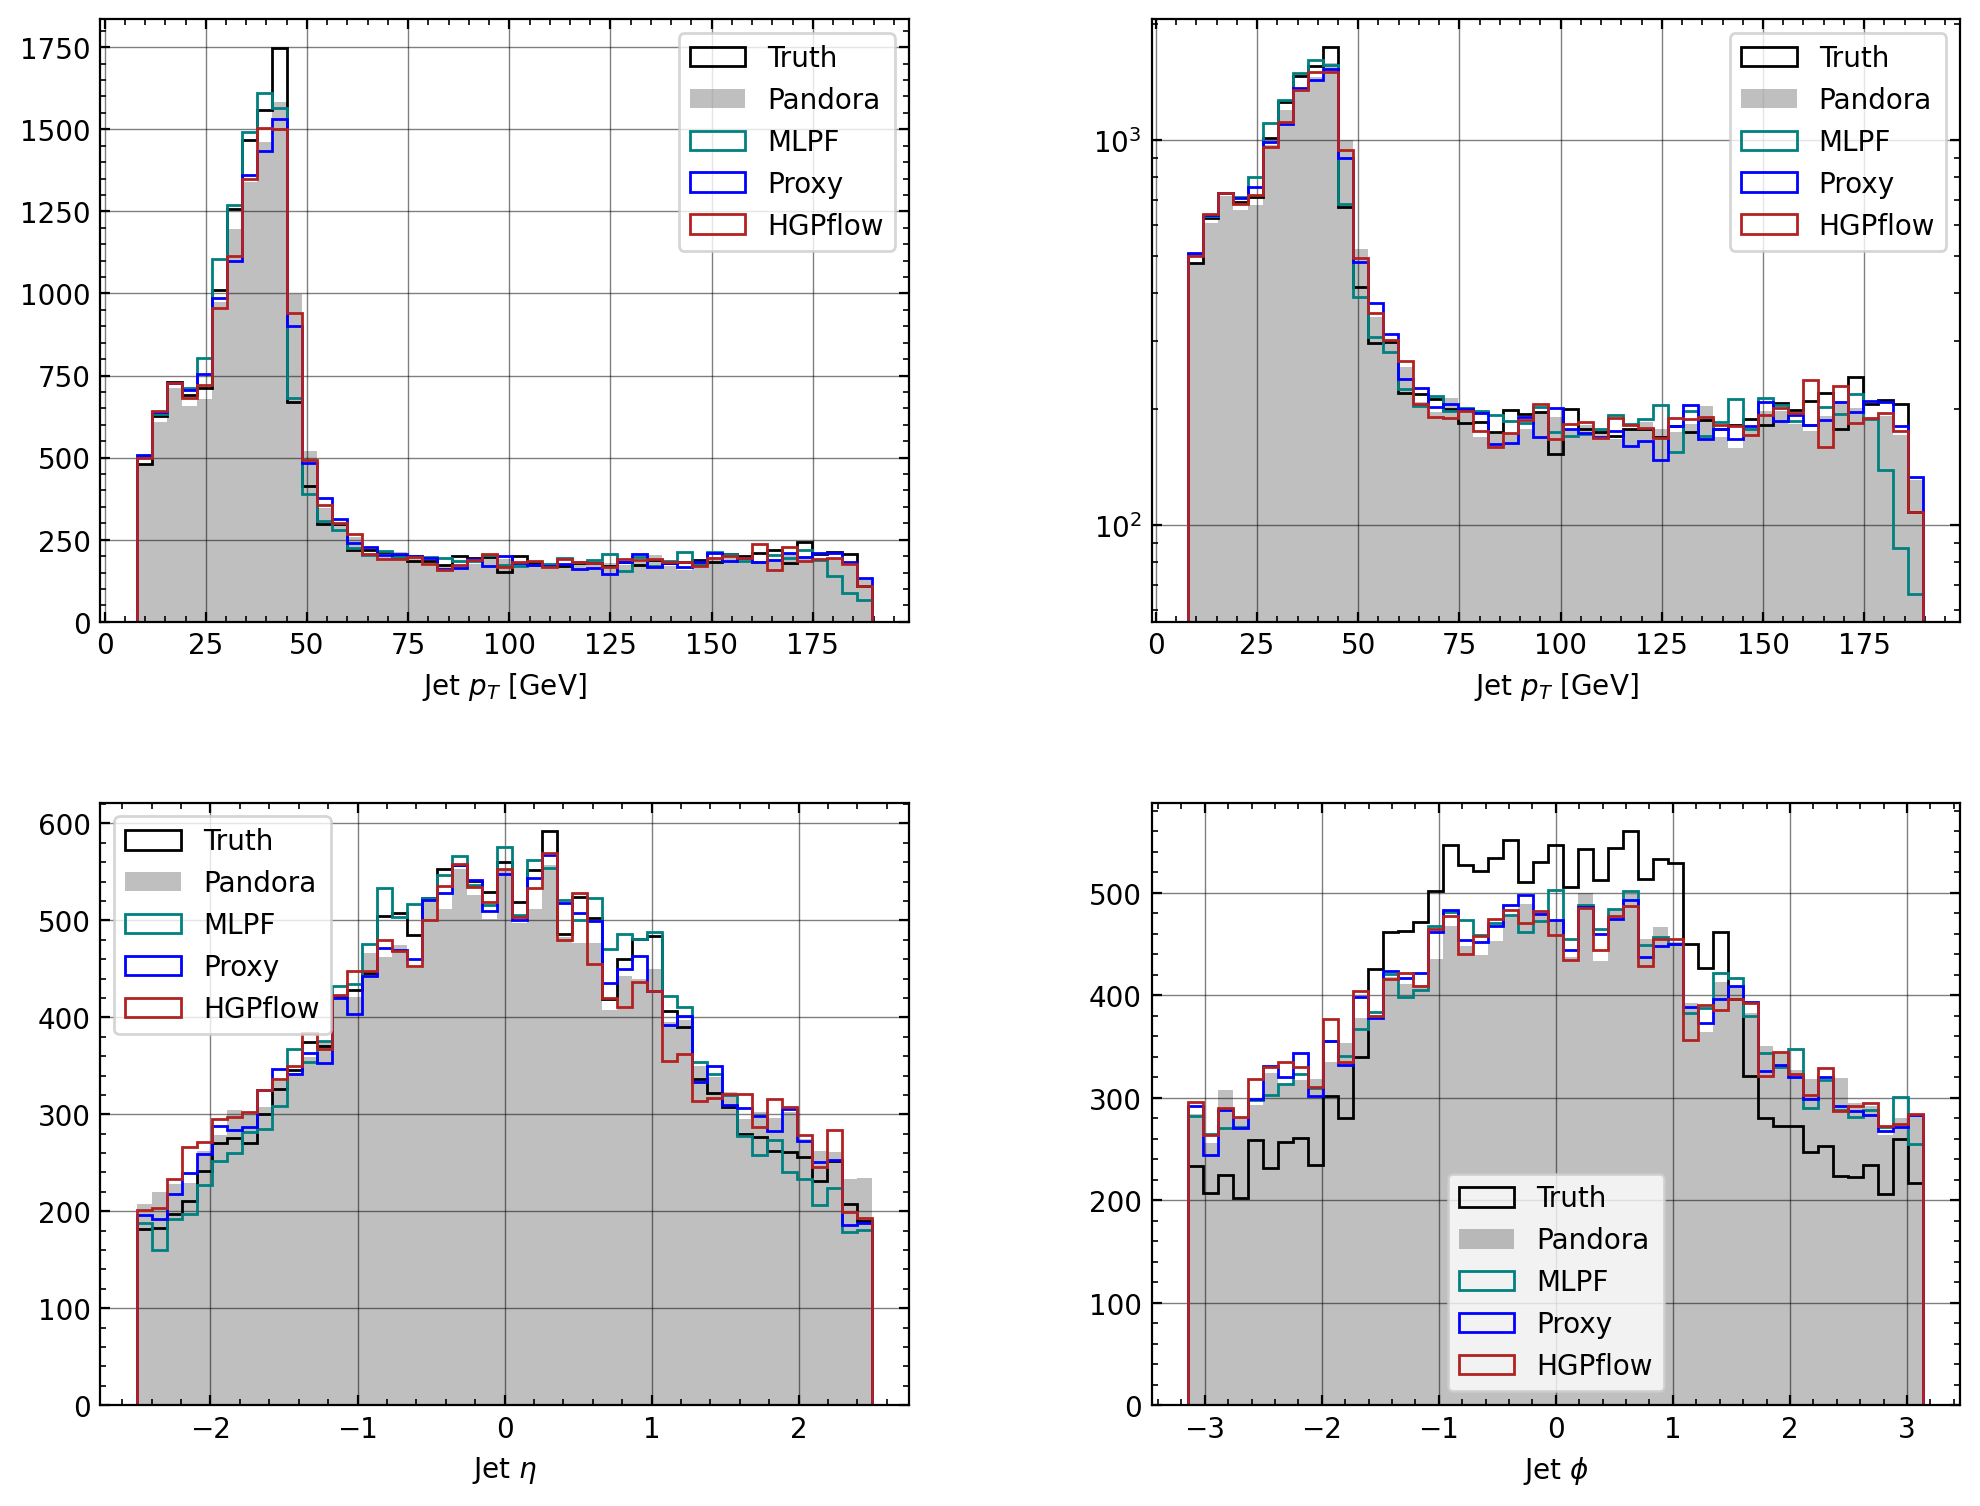

In [252]:
jet_dict = {
    "truth": perf_obj.truth_dict["truth_jets"],
    "pandora": perf_obj.truth_dict["pandora_jets"],
    "mlpf": perf_obj.data["mlpf"]["jets"],
    # 'mpflow': perf_obj.data['mpflow']['jets'],
    "proxy": perf_obj.data["mpflow"]["proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["jets"],
}

fig = plot_jet_marginals(jet_dict, nleading=1, stylesheet=None)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_marginals.png", dpi=300, bbox_inches="tight")

## Particle performance

In [228]:
perf_obj.hung_match_particles(flatten=True, return_unmatched=True)

Matching particles...: 100%|██████████| 19717/19717 [00:04<00:00, 4580.42it/s]


In [253]:
style_sheet_eff_fr = {
    "LINE_STYLES": {
        "proxy": "-",
        "pandora": "--",
        "mlpf": ":",
    },
    "COLORS": {
        "proxy": {
            "neut had": "mediumseagreen",
            "photon": "tomato",
        },
        "pandora": {
            "neut had": "dodgerblue",
            "photon": "goldenrod",
        },
        "mlpf": {
            "neut had": "crimson",
            "photon": "darkviolet",
        }
    },
}

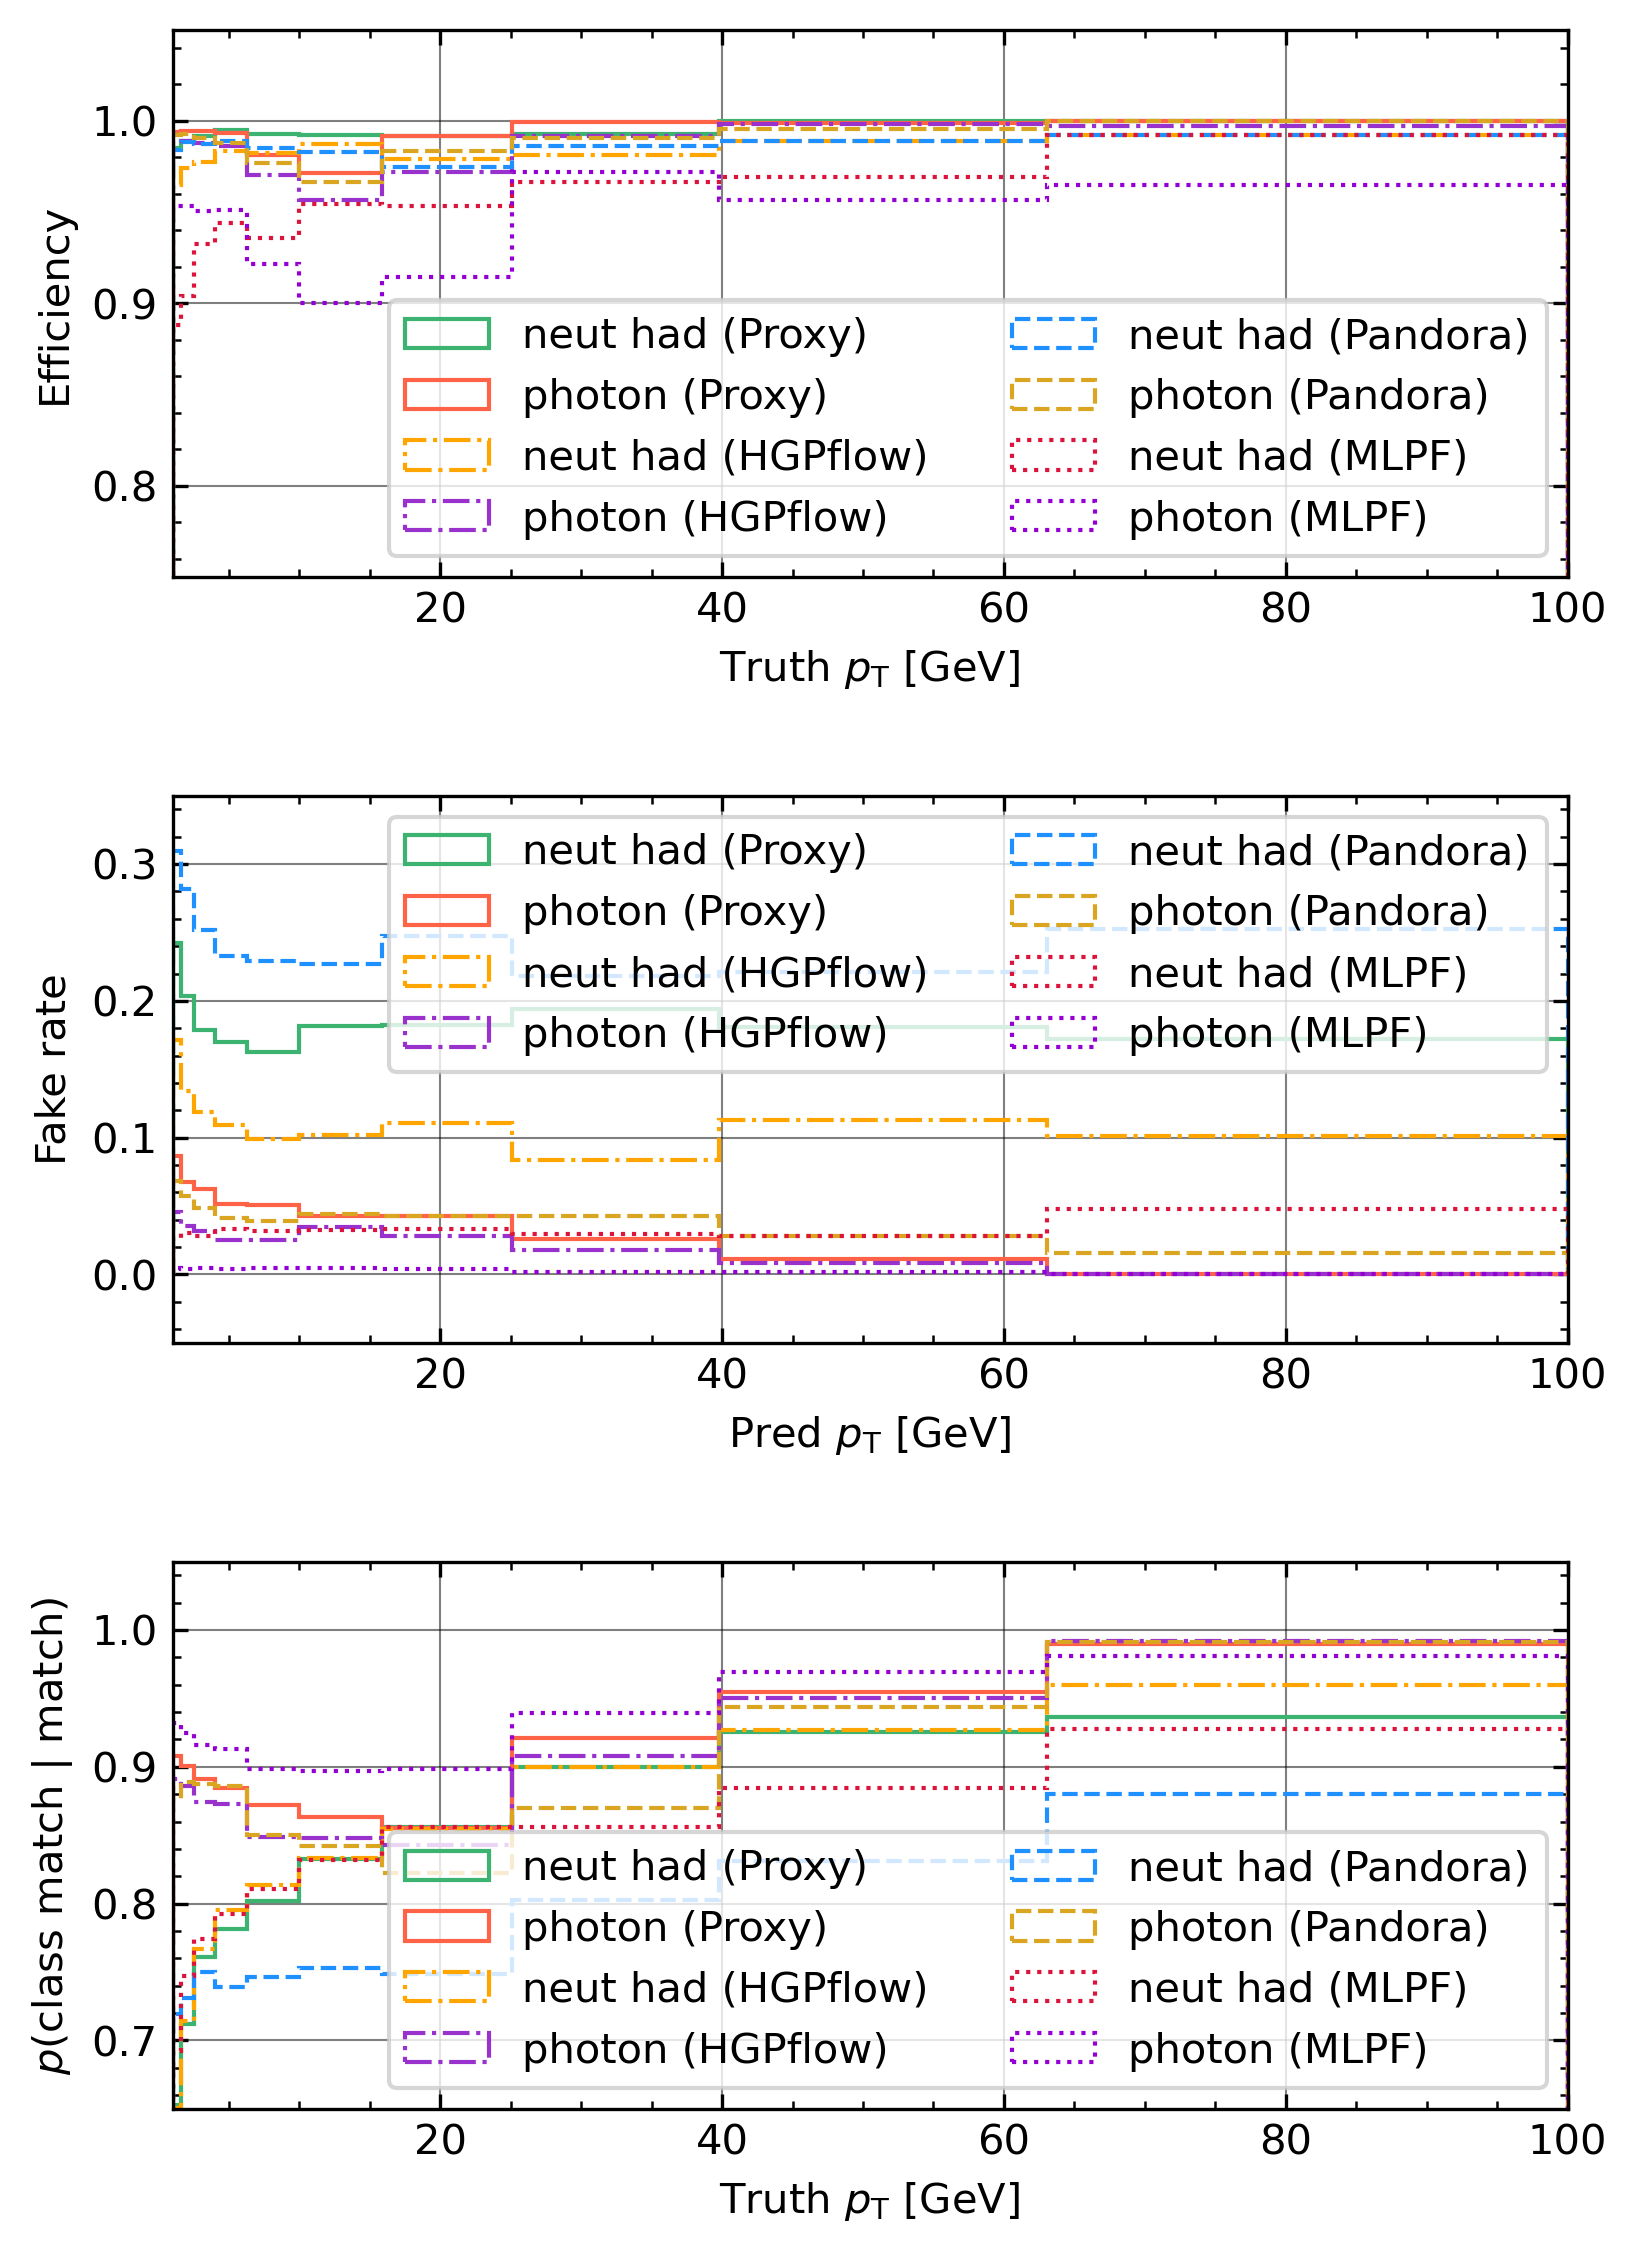

In [254]:
eff_fr_purity_input_dict = {
    "proxy": {
        "ref_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][3],
    },
    "pandora": {
        "ref_matched": perf_obj.truth_dict["matched_pandora_particles"][0],
        "comp_matched": perf_obj.truth_dict["matched_pandora_particles"][1],
        "ref_unmatched": perf_obj.truth_dict["matched_pandora_particles"][2],
        "comp_unmatched": perf_obj.truth_dict["matched_pandora_particles"][3],
    },
    "mlpf": {
        "ref_matched": perf_obj.data["mlpf"]["matched_particles"][0],
        "comp_matched": perf_obj.data["mlpf"]["matched_particles"][1],
        "ref_unmatched": perf_obj.data["mlpf"]["matched_particles"][2],
        "comp_unmatched": perf_obj.data["mlpf"]["matched_particles"][3],
    },
}

fig = plot_eff_fr_purity(eff_fr_purity_input_dict, stylesheet=style_sheet_eff_fr)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_eff_fr_purity.png", dpi=300, bbox_inches="tight")

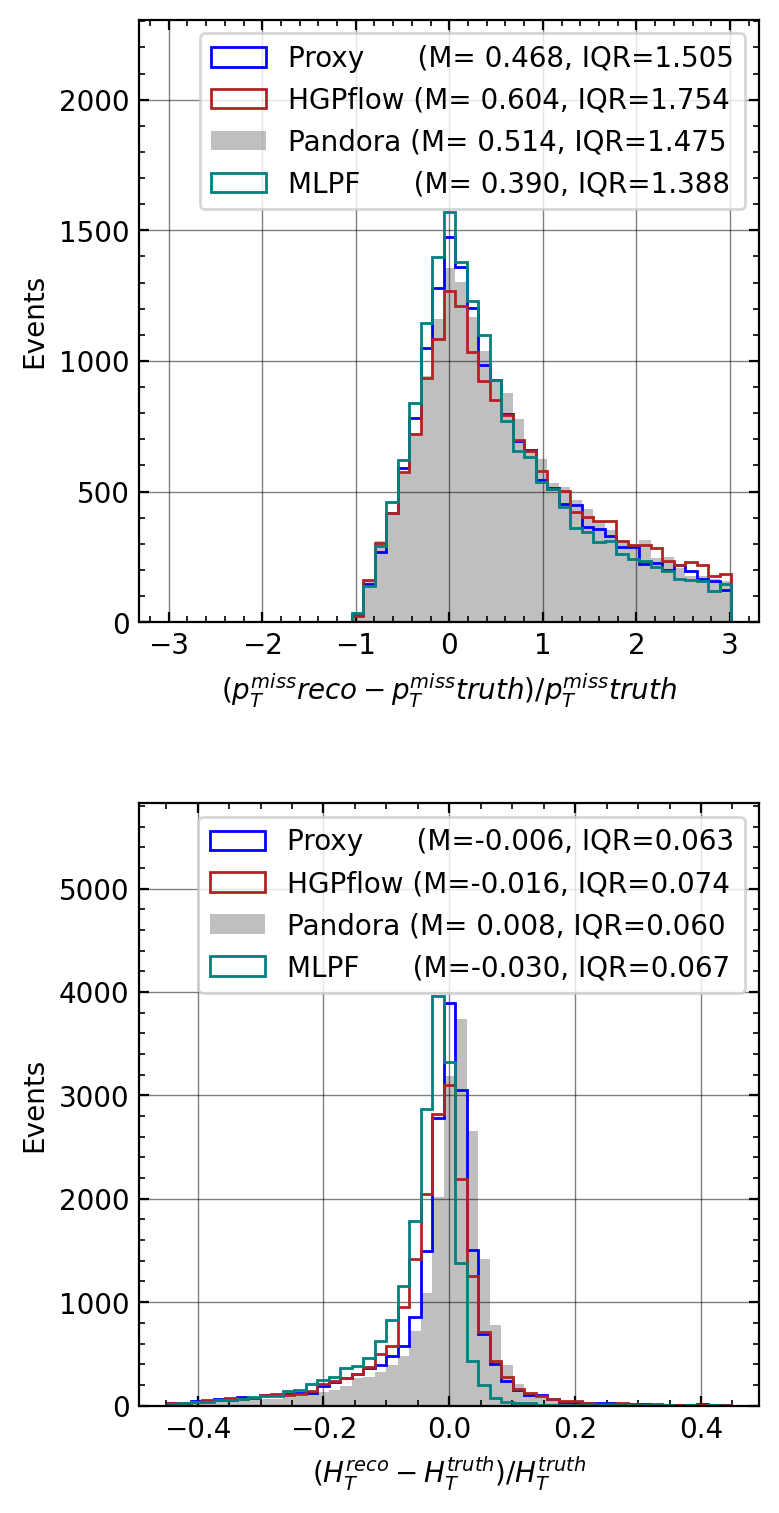

In [255]:
met_res_and_ht_res_input_dict = {
    "proxy": [perf_obj.data["mpflow"]["proxy_pt"], perf_obj.data["mpflow"]["proxy_phi"]],
    # "mpflow": [perf_obj.data["mpflow"]["pt"], perf_obj.data["mpflow"]["phi"]],
    "pandora": [perf_obj.truth_dict["pandora_pt"], perf_obj.truth_dict["pandora_phi"]],
    "mlpf": [perf_obj.data["mlpf"]["pt"], perf_obj.data["mlpf"]["phi"]],
}
figs = plot_met_res_and_ht_res(
    perf_obj.truth_dict["particle_pt"], perf_obj.truth_dict["particle_phi"], met_res_and_ht_res_input_dict, stylesheet=None, separate_figures=False
)
if SAVE_FIG:
    if isinstance(figs, list):
        for i, f in enumerate(figs):
            f.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res_{i}.png", dpi=300)
    else:
        figs.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res.png", dpi=300, bbox_inches="tight")

/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:135: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))
/tmp/ipykernel_3620034/463239206.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


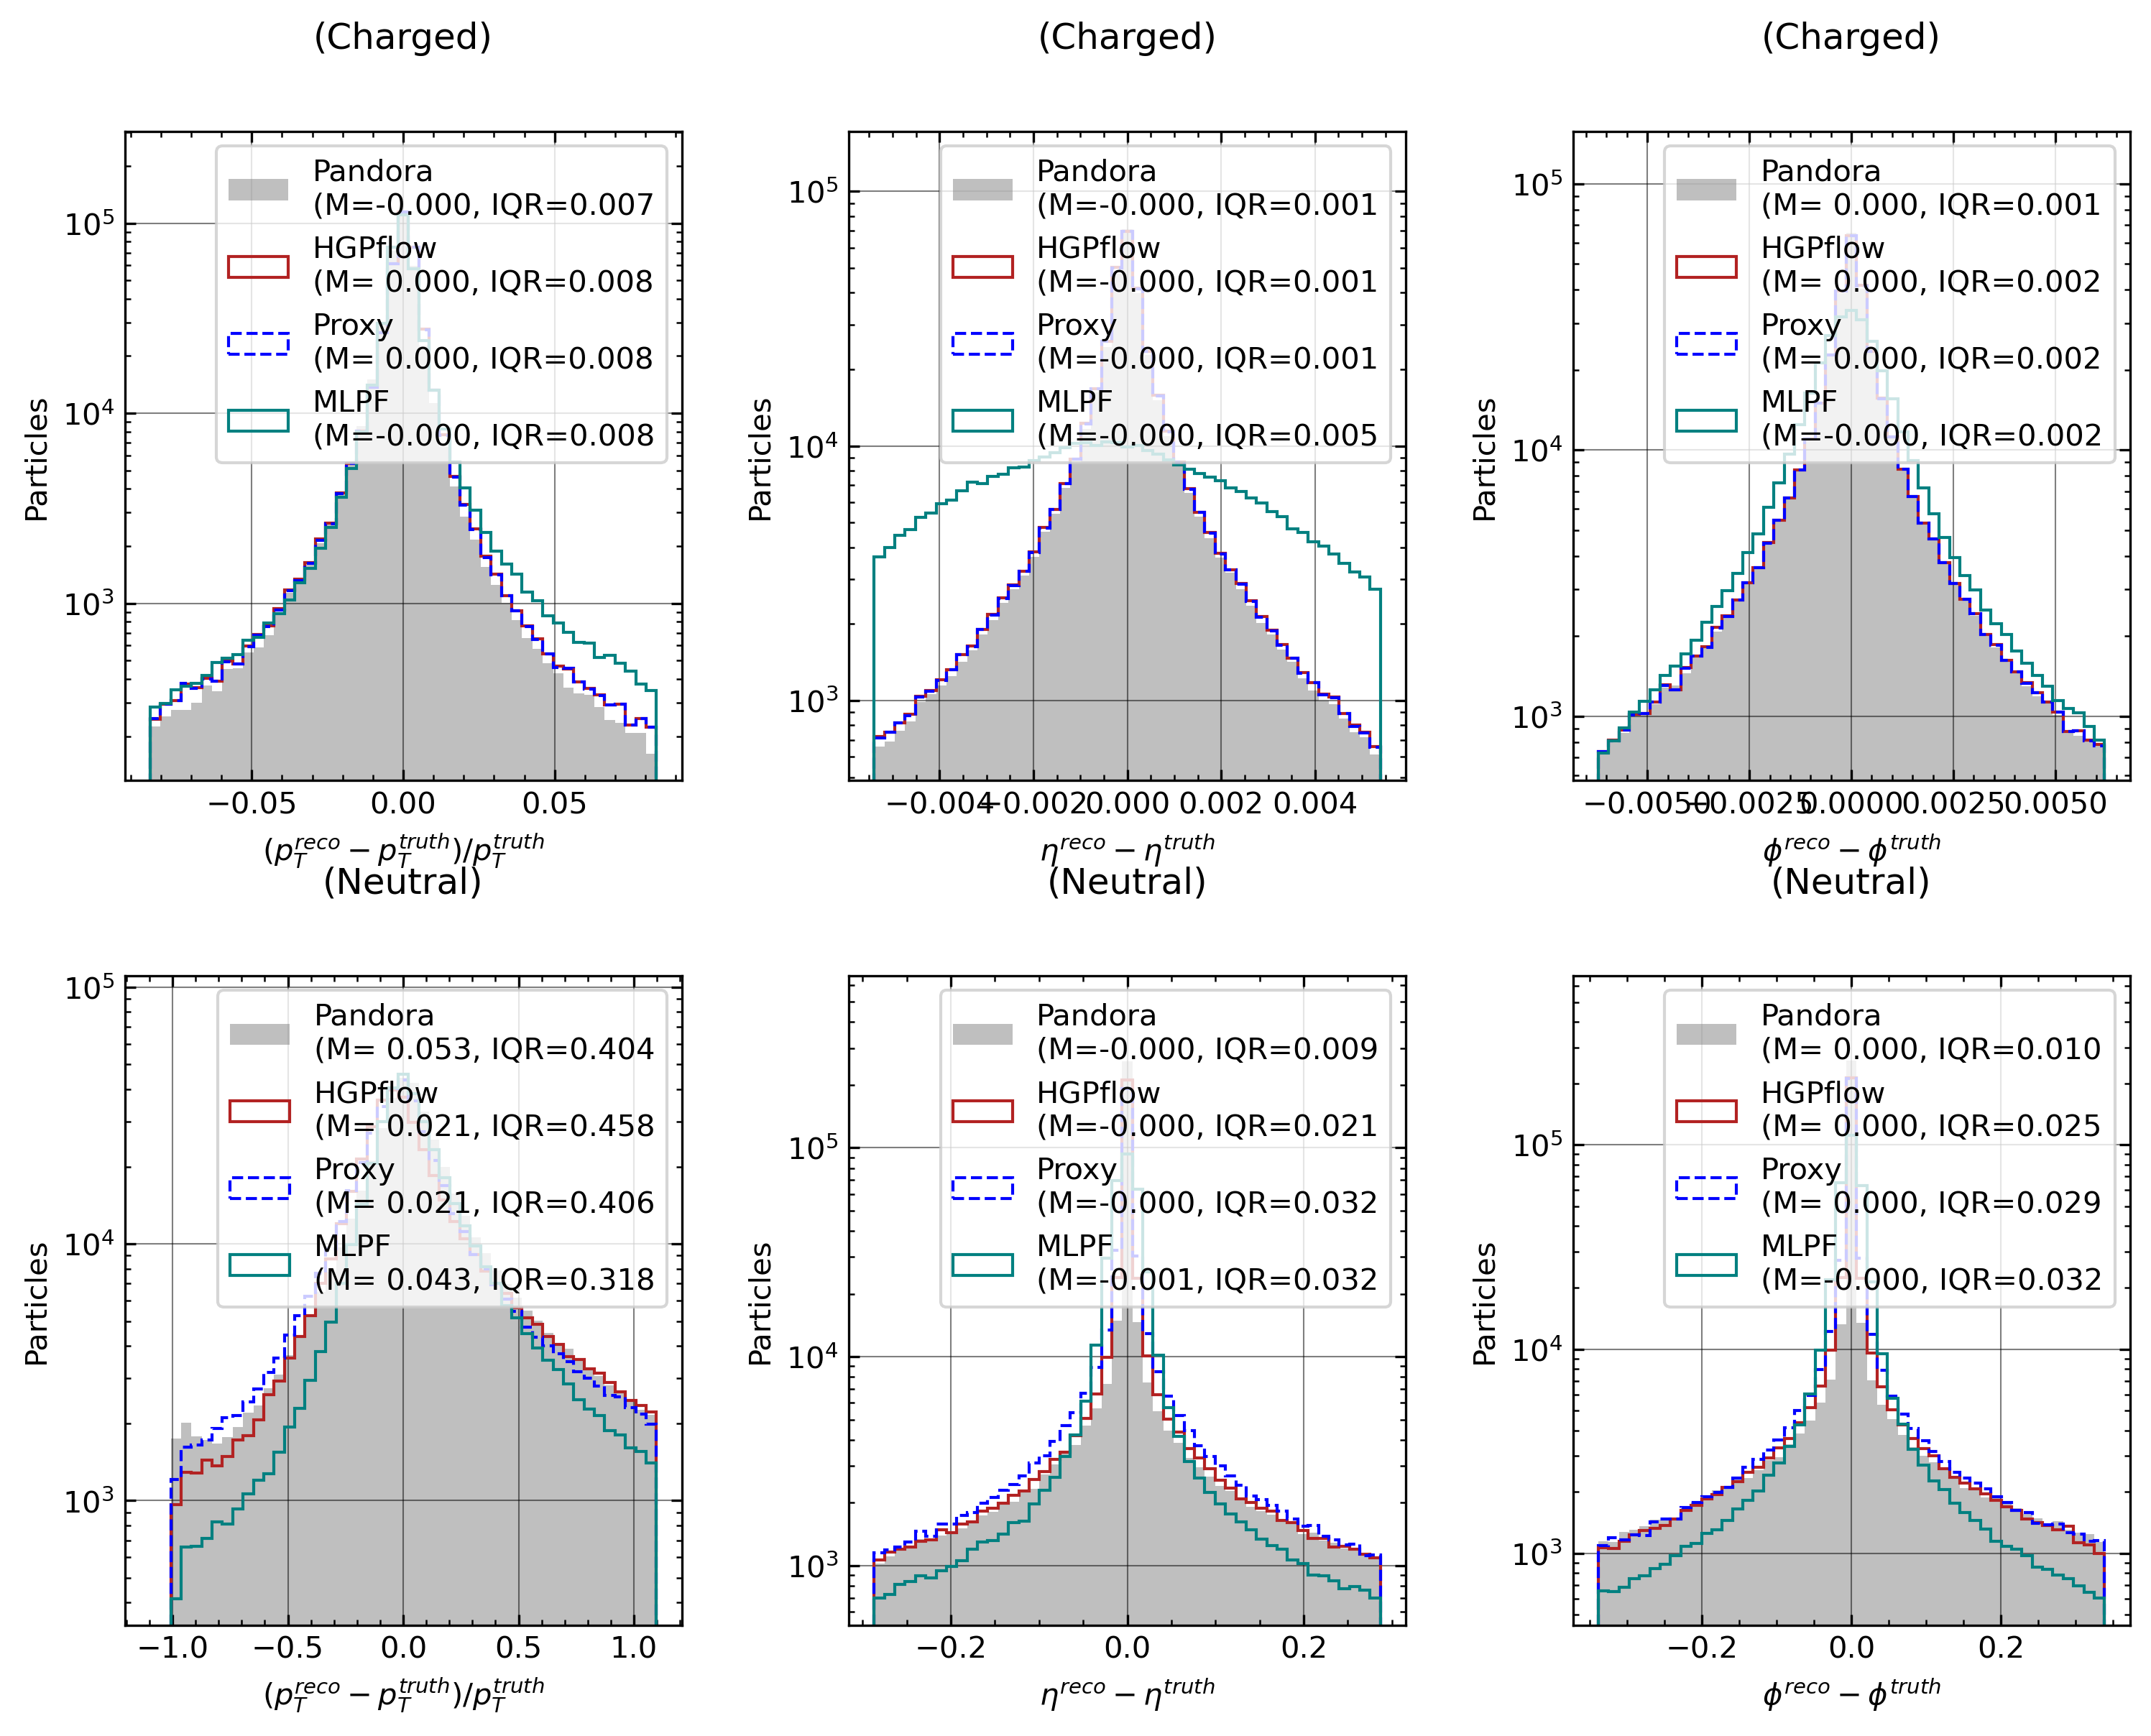

In [256]:
# from pflow.performance.plot_helper_particle import plot_residuals
from hepattn.experiments.clic.performance.style_sheet import LINE_STYLES

style_sheet_part_res = {
    "LINE_STYLES": deepcopy(LINE_STYLES),
}
style_sheet_part_res["LINE_STYLES"]["proxy"] = "--"
# style_sheet_part_res['COLORS']['proxy'] = 'dodgerblue'
# style_sheet_part_res['LINE_STYLES']['proxy'] = '-'

_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    # "mpflow": perf_obj.data["mpflow"]["matched_particles"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
    "mlpf": perf_obj.data["mlpf"]["matched_particles"],
}

qs = {"Charged": {"pt": 90, "eta": 80, "phi": 80}, "Neutral": {"pt": 90, "eta": 80, "phi": 80}}
fig = plot_residuals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=style_sheet_part_res)
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_particle_residuals.png", dpi=300, bbox_inches="tight")

In [257]:
_dict = {
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "hgpflow": perf_obj.data["hgpflow"]["matched_particles"],
    "mlpf": perf_obj.data["mlpf"]["matched_particles"],
}

qs = {"Neutral hadron": {"pt": 98, "eta": 75, "phi": 75}, "Photon": {"pt": 99, "eta": 90, "phi": 90}}
figs = plot_residuals_neutrals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=None, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_pt.png", dpi=300, bbox_inches="tight")
        figs[1].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_eta.png", dpi=300, bbox_inches="tight")
        figs[2].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_phi.png", dpi=300, bbox_inches="tight")
        figs[3].savefig(f"{save_dir}/dijet_particle_residuals_photon_pt.png", dpi=300, bbox_inches="tight")
        figs[4].savefig(f"{save_dir}/dijet_particle_residuals_photon_eta.png", dpi=300, bbox_inches="tight")
        figs[5].savefig(f"{save_dir}/dijet_particle_residuals_photon_phi.png", dpi=300, bbox_inches="tight")
    else:
        figs.savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_photon.png", dpi=300, bbox_inches="tight")

/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:234: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))


In [ ]:
perf_obj.hung_match_particles(flatten=False, return_unmatched=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_matched_event(idx):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    ref_class = perf_obj.data["mpflow"]["matched_proxy_particles"][0]["class"][idx]
    comp_class = perf_obj.data["mpflow"]["matched_proxy_particles"][1]["class"][idx]
    comp_class_hgpf = perf_obj.data["mpflow"]["matched_particles"][1]["class"][idx]
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["phi"][idx][ref_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["eta"][idx][ref_class < 3],
        marker="o",
        s=20,
        color="blue",
        label="Truth",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["phi"][idx][comp_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["eta"][idx][comp_class < 3],
        marker="x",
        s=20,
        color="orange",
        label="Proxy",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_particles"][1]["phi"][idx][comp_class_hgpf < 3],
        perf_obj.data["mpflow"]["matched_particles"][1]["eta"][idx][comp_class_hgpf < 3],
        marker="^",
        s=20,
        color="red",
        label="MPflow",
        alpha=0.5,
    )
    fig.suptitle(f"Event {idx}")
    ax.set_xlabel("Phi")
    ax.set_ylabel("Eta")
    fig.legend()
    fig.tight_layout()
    fig.show()

In [ ]:
plot_matched_event(0)